In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os

In [2]:
def RMSE(y_true, y_pred):
    'Normalized RMSE'
    RMSE = np.sqrt(((y_true - y_pred) ** 2).sum() / (y_true ** 2).sum())
    return RMSE

In [3]:
def plot(y_true, y_pred, border = 100):
    fig = plt.figure(figsize=(18,12))
    # set up subplot grid
    gridspec.GridSpec(2,2)
    
    #Big subplot with diagonal plot
    plt.subplot2grid((2,3), (0,0), colspan=2, rowspan=2)
    plt.xlim(0, border)
    plt.ylim(0, border)
    plt.scatter(y_true, y_pred,  s = 10)
    plt.plot([0, border], [0, border], c = 'red', alpha = 0.6)
    plt.plot([0, border * 1/1.15], [0, border], color = 'black', alpha = 0.6, linewidth = 2, linestyle = '--')
    plt.plot([0, border], [0, border * 0.85], color = 'black', alpha = 0.6, linewidth = 2, linestyle = '--')
    plt.xlabel('True values', fontsize = 20)
    plt.ylabel('Forecast values', fontsize = 20)
    plt.tick_params(labelsize = 20)
    plt.grid()

In [4]:
def CV_estimator_with_sigma(estimator, X, y):
    cv = RepeatedKFold(n_splits=4, n_repeats=5, random_state=3)
    scoring = {'r2': 'r2',
               'mae': 'neg_mean_absolute_error',
               'mse': 'neg_mean_squared_error',
               'n-rmse': make_scorer(RMSE, greater_is_better=False)
              } 
    scores = cross_validate(estimator, X, y, scoring=scoring, cv=cv, return_train_score=True)
    print('Model gives R2: %.3f +- %.3f' % (scores['test_r2'].mean(), 2*scores['test_r2'].std()))
    print('Model gives MAE: %.3f +- %.3f' % (abs(scores['test_mae']).mean(), 2*abs(scores['test_mae']).std()))
    print('Model gives MSE: %.3f +- %.3f' % (abs(scores['test_mse']).mean(), 2*abs(scores['test_mse']).std()))
    return scores

In [5]:
def optimal_params_search(estimator, params, X, y, scoring = 'r2'):
    param_grid = {}
    best_params = {}
    for i, param in enumerate(params):
        regr = estimator(**best_params)
        g_search = GridSearchCV(regr, param_grid = param, scoring=scoring, n_jobs=-1, cv=5)
        g_search.fit(X, y)
        best_params.update(g_search.best_params_)
    return best_params, g_search

In [6]:
path_gas_test = 'Geochemistry Data/CNS_gas_test.csv'
path_gas_train = 'Geochemistry Data/CNS_gas_train.csv'
path_rock_samples = 'Geochemistry Data/CNS_rock_samples.csv'
df_test = pd.read_csv(path_gas_test, skiprows = [1], header = 0)
df_train = pd.read_csv(path_gas_train, skiprows = [1], header = 0)
df_rock = pd.read_csv(path_rock_samples, skiprows = [1], header = 0)
df_train['WH_LONG'].values[-5] = df_train['WH_LONG'].values[-4]
df_train['WH_LONG'] = df_train['WH_LONG'].astype(float)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (0,1,2,3,4,5,8,9,15,17,20,21,22,23,24,25,27,28,29,30,31,32,33,34,36,42,43,44,46,47,48,56,57,58,92,93,99,100,101,102) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
df_train['WH_SPUD_DATE_upd'] = pd.to_datetime(df_train['WH_SPUD_DATE'], format='%d/%m/%Y %H:%M', errors='coerce')
mask = df_train['WH_SPUD_DATE_upd'].isnull()
df_train.loc[mask, 'WH_SPUD_DATE_upd'] = pd.to_datetime(df_train[mask]['WH_SPUD_DATE'],
                                                        format='%d-%m-%y %H:%M', errors='coerce')
df_train['WH_SPUD_DATE'] = df_train['WH_SPUD_DATE_upd']

df_train['WH_COMP_DATE_upd'] = pd.to_datetime(df_train['WH_COMP_DATE'], format='%d/%m/%Y %H:%M', errors='coerce')
mask = df_train['WH_COMP_DATE_upd'].isnull()
df_train.loc[mask, 'WH_COMP_DATE_upd'] = pd.to_datetime(df_train[mask]['WH_COMP_DATE'],
                                                        format='%d-%m-%y %H:%M', errors='coerce')
df_train['WH_COMP_DATE'] = df_train['WH_COMP_DATE_upd']

In [8]:
# df_test['WH_SPUD_DATE'] = pd.to_datetime(df_test['WH_SPUD_DATE'], format='%m/%d/%Y %H:%M')
# df_test['WH_COMP_DATE'] = pd.to_datetime(df_test['WH_COMP_DATE'], format='%m/%d/%Y %H:%M')

# df_oil['WH_SPUD_DATE'] = pd.to_datetime(df_oil['WH_SPUD_DATE'], format='%b %d, %Y')
# df_oil['WH_COMP_DATE'] = pd.to_datetime(df_oil['WH_COMP_DATE'], format='%b %d, %Y')

In [195]:
intersections = list(set(df_test['WELL_NAME'].to_list()) & set(df_rock['WELL_NAME'].to_list()))
intersections

['015/18A-06S1',
 '022/29-02',
 '020/03-04',
 '022/24b-05',
 '029/08a-03',
 '021/30-13A']

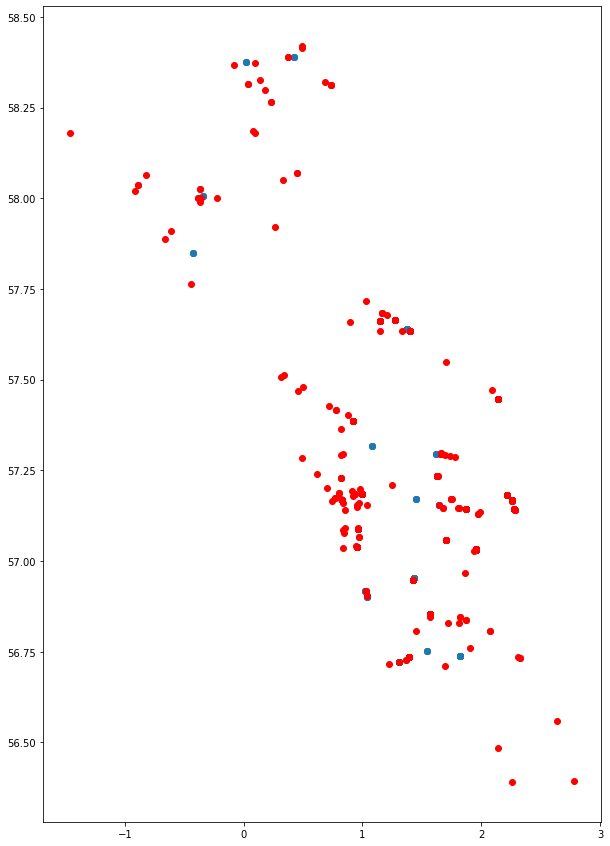

In [196]:
plt.figure(figsize = (10, 15))
df_train['WH_LONG'].iloc[-5] = df_train['WH_LONG'].iloc[-4]
df_train['WH_LONG'] = df_train['WH_LONG'].astype(float)
plt.scatter(df_test['WH_LONG'], df_test['WH_LAT'])
plt.scatter(df_train['WH_LONG'], df_train['WH_LAT'], color = 'red')

In [197]:
for col in df_test.isna().sum()[df_test.isna().sum() < 50].index.to_list():
    print('COL NAME', col)
    print(df_test[col].to_list())
    print('__________________________')

COL NAME Country
['United Kingdom', 'United Kingdom', 'United Kingdom', 'United Kingdom', 'United Kingdom', 'United Kingdom', 'United Kingdom', 'United Kingdom', 'United Kingdom', 'United Kingdom', 'United Kingdom', 'United Kingdom', 'United Kingdom', 'United Kingdom', 'United Kingdom', 'United Kingdom', 'United Kingdom', 'United Kingdom', 'United Kingdom', 'United Kingdom', 'United Kingdom', 'United Kingdom', 'United Kingdom', 'United Kingdom', 'United Kingdom', 'United Kingdom', 'United Kingdom', 'United Kingdom', 'United Kingdom', 'United Kingdom', 'United Kingdom', 'United Kingdom', 'United Kingdom', 'United Kingdom', 'United Kingdom', 'United Kingdom', 'United Kingdom', 'United Kingdom', 'United Kingdom', 'United Kingdom', 'United Kingdom', 'United Kingdom', 'United Kingdom', 'United Kingdom', 'United Kingdom', 'United Kingdom', 'United Kingdom', 'United Kingdom', 'United Kingdom', 'United Kingdom', 'United Kingdom', 'United Kingdom', 'United Kingdom', 'United Kingdom', 'United Ki

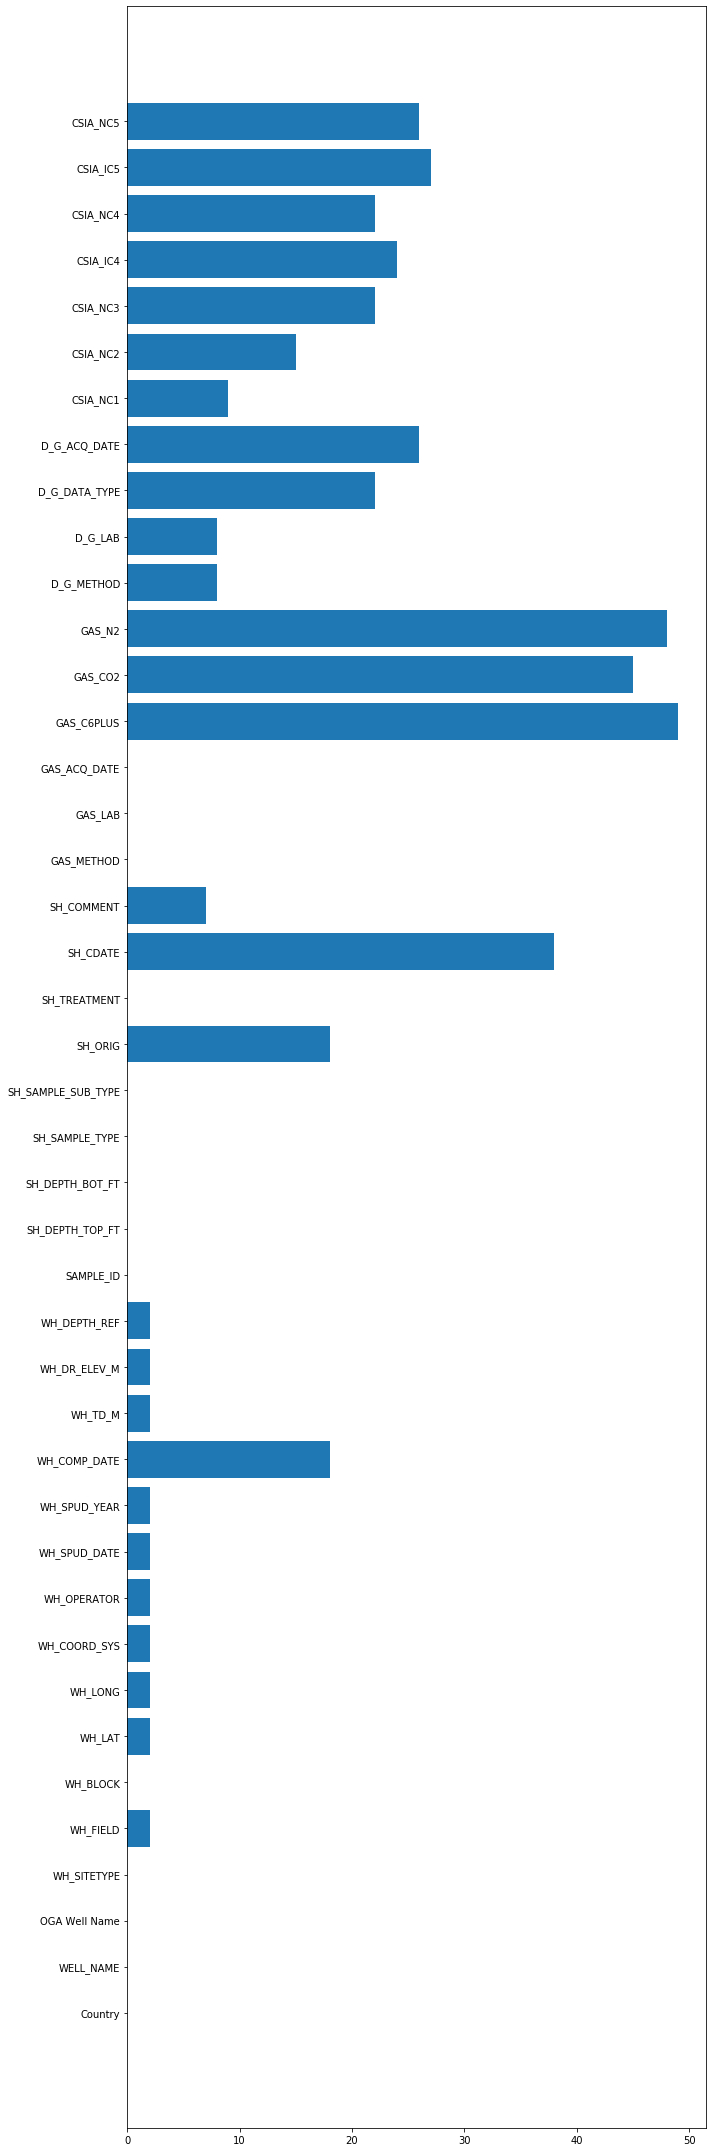

In [198]:
plt.figure(figsize = (10, 30))
plt.barh(df_test.isna().sum()[df_test.isna().sum() < 50].index,
         df_test.isna().sum()[df_test.isna().sum() < 50].values)
plt.tight_layout()
plt.savefig('diag.png')

In [ ]:
# cols = [
#     'WH_LAT', 'WH_LONG', 'WH_TD_M', 'WH_DR_ELEV_M', 'WH_DEPTH_REF', 'SH_DEPTH_TOP_FT', 'SH_DEPTH_BOT_FT',
#     'SH_SAMPLE_TYPE', 'SH_SAMPLE_SUB_TYPE', 'SH_ORIG', 'GAS_LAB', 'CSIA_NC1', 'CSIA_NC2', 'CSIA_NC3',
#     'CSIA_IC4', 'CSIA_NC4', 'CSIA_IC5', 'CSIA_NC5'
# ]

# cols = [
#     'WH_LAT', 'WH_LONG', 'WH_TD_M', 'SH_DEPTH_TOP_FT', 'SH_DEPTH_BOT_FT', 'CSIA_CONC_C1', 'CSIA_NC1', 'CSIA_NC2',
#        'CSIA_NC3', 'CSIA_IC4', 'CSIA_NC4', 'CSIA_IC5', 'CSIA_NC5'
# ]
# X_test = df_test[cols]
# X_train = df_train[cols]

#y_train = df_train[['GAS_C1', 'GAS_C2', 'GAS_C3', 'GAS_IC4', 'GAS_NC4', 'GAS_IC5', 'GAS_NC5']]

In [199]:
df_train[df_train.duplicated()]

,Country,WELL_NAME,OGA Well Name,WH_SITETYPE,WH_FIELD,WH_BLOCK,WH_LAT,WH_LONG,WH_COORD_SYS,WH_OPERATOR,...,DD_G_GAS,DD_G_NC1,DD_G_NC2,DD_G_NC3,DD_G_IC4,DD_G_NC4,DD_G_IC5,DD_G_NC5,WH_SPUD_DATE_upd,WH_COMP_DATE_upd


In [9]:
X_train = df_train.copy()
X_test = df_test.copy()

In [10]:
X_train.isna().sum()

Country                0
WELL_NAME              0
OGA Well Name          0
WH_SITETYPE            0
WH_FIELD              53
                    ... 
DD_G_NC4            1709
DD_G_IC5            1709
DD_G_NC5            1709
WH_SPUD_DATE_upd     120
WH_COMP_DATE_upd     893
Length: 93, dtype: int64

In [54]:
X_test.isna().sum()

Country           0
WELL_NAME         0
OGA Well Name     0
WH_SITETYPE       0
WH_FIELD          2
                 ..
DD_G_NC3         99
DD_G_IC4         99
DD_G_NC4         99
DD_G_IC5         99
DD_G_NC5         99
Length: 91, dtype: int64

In [11]:
X_train.dropna(subset=['WH_LAT'], inplace = True)
#X_test.dropna(subset=['WH_LAT'], inplace = True)

In [12]:
cols = [
    'WH_LAT', 'WH_LONG', 'WH_TD_M', 'SH_DEPTH_TOP_FT', 'SH_DEPTH_BOT_FT', 'CSIA_CONC_C1', 'CSIA_NC1', 'CSIA_NC2',
       'CSIA_NC3', 'CSIA_IC4', 'CSIA_NC4', 'CSIA_IC5', 'CSIA_NC5'
]

y_train = X_train[['GAS_C1', 'GAS_C2', 'GAS_C3', 'GAS_IC4', 'GAS_NC4', 'GAS_IC5', 'GAS_NC5']]
X_test = X_test[cols]
X_train = X_train[cols]

In [13]:
from scipy.spatial import cKDTree
from sklearn.neighbors import KDTree

In [14]:
X_train_filled = X_train.copy()
X_test_filled = X_test.copy()

In [15]:
coords = X_train[['WH_LONG', 'WH_LAT']].values
tree = KDTree(coords, leaf_size=2) 
for col in X_train.isna().sum().index:
    print(col)
    idxs_to_fill = X_train.index[X_train[col].isnull()]
    for idx in idxs_to_fill:
        coord = [X_train[['WH_LONG', 'WH_LAT']].loc[idx].values]
        #print(coord)
        dist, ind = tree.query(coord, k=300)  
        df_neib_vals = pd.DataFrame({'param': X_train.iloc[ind[0]][col].to_list(), 'weights': dist[0]})
        df_neib_vals.dropna(inplace=True)
        df_neib_vals = df_neib_vals[df_neib_vals['weights'] != 0]
        df_neib_vals['weights'] = 1/df_neib_vals['weights'].values
        X_train_filled[col].loc[idx] = np.average(np.array(df_neib_vals['param'], dtype=float),
                                     weights=np.array(df_neib_vals['weights'], dtype=float))
        #print(X_train_filled[col].loc[idx], X_train[col].mean(), df_neib_vals['param'].mean())

WH_LAT
WH_LONG
WH_TD_M
SH_DEPTH_TOP_FT
SH_DEPTH_BOT_FT
CSIA_CONC_C1
CSIA_NC1
CSIA_NC2
CSIA_NC3
CSIA_IC4
CSIA_NC4
CSIA_IC5
CSIA_NC5


In [20]:
X_train_filled.isna().sum()

WH_LAT             0
WH_LONG            0
WH_TD_M            0
SH_DEPTH_TOP_FT    0
SH_DEPTH_BOT_FT    0
CSIA_CONC_C1       0
CSIA_NC1           0
CSIA_NC2           0
CSIA_NC3           0
CSIA_IC4           0
CSIA_NC4           0
CSIA_IC5           0
CSIA_NC5           0
dtype: int64

In [17]:
idxs_to_fill = X_test.index[X_test['WH_LONG'].isnull()]
for idx in idxs_to_fill:
    X_test['WH_LONG'].loc[idx] = X_test['WH_LONG'].mean()
    X_test['WH_LAT'].loc[idx] = X_test['WH_LAT'].mean()

In [18]:
X_test_filled = X_test.copy()
coords = X_test[['WH_LONG', 'WH_LAT']].values
tree = KDTree(coords, leaf_size=2) 
for col in X_test.isna().sum().index:
    print(col)
    idxs_to_fill = X_test.index[X_test[col].isnull()]
    for idx in idxs_to_fill:
        coord = [X_test[['WH_LONG', 'WH_LAT']].loc[idx].values]
        #print(coord)
        dist, ind = tree.query(coord, k=50)  
        df_neib_vals = pd.DataFrame({'param': X_test.iloc[ind[0]][col].to_list(), 'weights': dist[0]})
        df_neib_vals.dropna(inplace=True)
        df_neib_vals = df_neib_vals[df_neib_vals['weights'] != 0]
        df_neib_vals['weights'] = 1/df_neib_vals['weights'].values
        X_test_filled[col].loc[idx] = np.average(np.array(df_neib_vals['param'], dtype=float),
                                     weights=np.array(df_neib_vals['weights'], dtype=float))
        #print(X_test[col].loc[idx], X_test[col].mean())

WH_LAT
WH_LONG
WH_TD_M
SH_DEPTH_TOP_FT
SH_DEPTH_BOT_FT
CSIA_CONC_C1
CSIA_NC1
CSIA_NC2
CSIA_NC3
CSIA_IC4
CSIA_NC4
CSIA_IC5
CSIA_NC5


In [21]:
X_test_filled.isna().sum()

WH_LAT             0
WH_LONG            0
WH_TD_M            0
SH_DEPTH_TOP_FT    0
SH_DEPTH_BOT_FT    0
CSIA_CONC_C1       0
CSIA_NC1           0
CSIA_NC2           0
CSIA_NC3           0
CSIA_IC4           0
CSIA_NC4           0
CSIA_IC5           0
CSIA_NC5           0
dtype: int64

In [38]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.multioutput import MultiOutputRegressor as MOR
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold, GridSearchCV, RepeatedKFold, cross_validate
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV
import xgboost as xgb
import warnings
from sklearn.cluster import KMeans, AffinityPropagation, MeanShift, SpectralClustering, AgglomerativeClustering,\
FeatureAgglomeration, Birch, OPTICS
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor

In [23]:
warnings.simplefilter('ignore')

In [24]:
for col in X_test_filled.dtypes[X_test_filled.dtypes == 'object'].index:
    X_train_filled[col] = X_train_filled[col].where(X_train_filled[col] == X_train_filled[col], 'No data')
    X_test_filled[col] = X_test_filled[col].where(X_test_filled[col] == X_test_filled[col], 'No data')
    le = LabelEncoder()
    X_train_filled[col] = le.fit_transform(X_train_filled[col])
    X_test_filled[col] = le.fit_transform(X_test_filled[col])

### XGBoost

In [27]:
XG_tune_params = [
    {
        'objective': ['reg:squarederror'],
        'booster': ['gbtree'],
        'silent': [True]
    },
    {
        'learning_rate': [0.01, 0.25, 0.05, 0.075, 0.1],
    },
    {
        'n_estimators': [50, 100, 200, 300],
    },
    {
        'max_depth':np.linspace(1,10,6, dtype = int),
        'min_child_weight':np.linspace(1,10,6, dtype = int),
    },
    {
        'subsample':[i/10.0 for i in range(5,11)],
        'colsample_bytree':[i/10.0 for i in range(5,11)],
    },
    {
        'reg_alpha':[0, 1e-5, 1e-3, 0.1, 1],
        'reg_lambda': [0, 1e-5, 1e-3, 0.1, 1]
    }
]

In [28]:
X = X_train_filled.copy()

In [216]:
rankings = []
params = []
r2_s = [None]*7
mae_s = [None]*7
mse_s = [None]*7
std_r2_s = [None]*7
std_mae_s = [None]*7
std_mse_s = [None]*7
y_preds = y_train.copy()
for i in range(y_train.shape[1]):
    print('FORECAST: ', i)
    y = y_train.iloc[:, i].copy()

    XG_params, _ = optimal_params_search(xgb.XGBRegressor, XG_tune_params, X.copy(), y)
    
    scores = CV_estimator_with_sigma(xgb.XGBRegressor(**XG_params), X.copy(), y)
    params.append(XG_params)
    y_preds.iloc[:, i] = cross_val_predict(xgb.XGBRegressor(**XG_params), X.copy(), y)
    r2_s[i] = scores['test_r2'].mean()
    mae_s[i] = abs(scores['test_mae']).mean()
    mse_s[i] = abs(scores['test_mse']).mean()
    std_r2_s[i] = 2*scores['test_r2'].std()
    std_mae_s[i] = 2*abs(scores['test_mae']).std()
    std_mse_s[i] = 2*abs(scores['test_mse']).std()

FORECAST:  0
Model gives R2: 0.378 +- 0.073
Model gives MAE: 6.864 +- 0.883
Model gives MSE: 140.281 +- 43.338
FORECAST:  1
Model gives R2: 0.557 +- 0.067
Model gives MAE: 1.840 +- 0.134
Model gives MSE: 8.064 +- 1.444
FORECAST:  2
Model gives R2: 0.495 +- 0.105
Model gives MAE: 1.074 +- 0.099
Model gives MSE: 4.326 +- 1.576
FORECAST:  3
Model gives R2: 0.183 +- 0.093
Model gives MAE: 0.227 +- 0.019
Model gives MSE: 0.142 +- 0.062
FORECAST:  4
Model gives R2: 0.247 +- 0.126
Model gives MAE: 0.519 +- 0.067
Model gives MSE: 1.028 +- 0.600
FORECAST:  5
Model gives R2: -0.120 +- 0.296
Model gives MAE: 0.289 +- 0.031
Model gives MSE: 0.217 +- 0.198
FORECAST:  6
Model gives R2: 0.093 +- 0.130
Model gives MAE: 0.322 +- 0.051
Model gives MSE: 0.385 +- 0.365


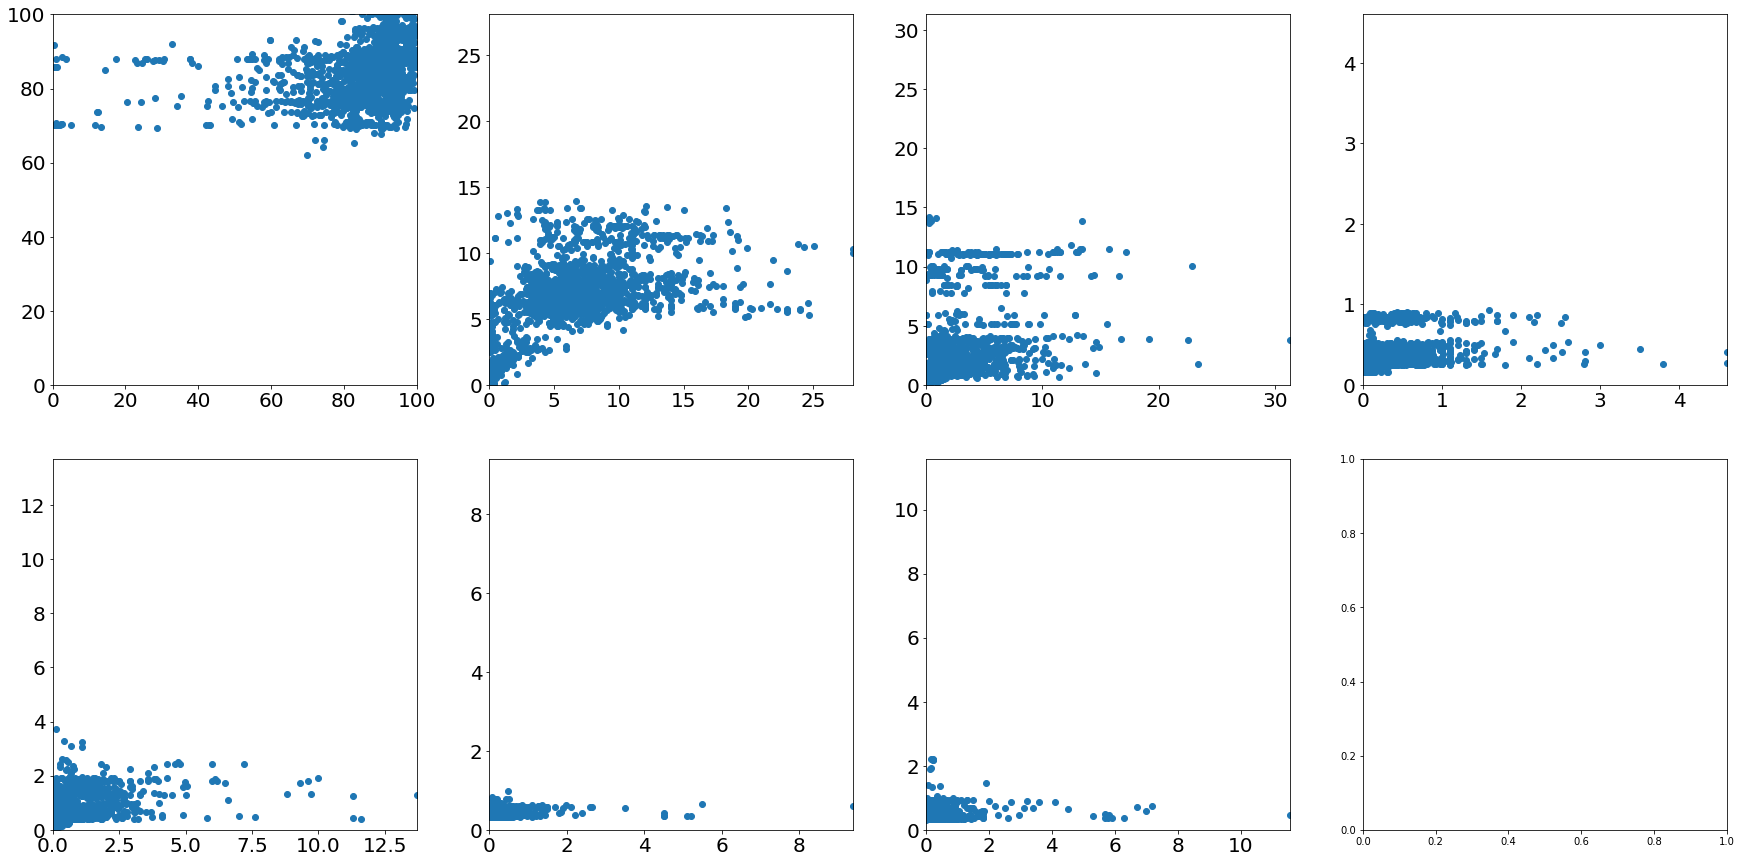

In [217]:
width = 4
height = 2
f, ax = plt.subplots(nrows = height, ncols = width, figsize=(30,15))
for i in range(7):
    ax[i//width, i % width].set_xlim(0, y_train.iloc[:, i].max())
    ax[i//width, i % width].set_ylim(0, y_train.iloc[:, i].max())
    ax[i//width, i % width].tick_params(labelsize = 20)
    ax[i//width, i % width].scatter(y_train.iloc[:, i], y_preds.iloc[:, i])
    
    #df[df[col] !=0].hist([col], ax = ax[i//width, i % width], bins = 100)
    #ax[i//width, i % width].title.set_size(18)
#plt.savefig('Params_distributions.png')
plt.show()

### Nearest neighbours

In [219]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [220]:
y_preds_neib = y_train.copy()
for i in range(y_train.shape[1]):
    print('FORECAST: ', i)
    y = y_train.iloc[:, i].copy()

    neib_params, _ = optimal_params_search(KNeighborsRegressor, [{'n_neighbors':[5,10,15,20,25,30,35,40]}], X_scaled.copy(), y)
    
    scores = CV_estimator_with_sigma(KNeighborsRegressor(**neib_params), X_scaled.copy(), y)
    y_preds_neib.iloc[:, i] = cross_val_predict(KNeighborsRegressor(**neib_params), X_scaled.copy(), y)

FORECAST:  0
Model gives R2: 0.215 +- 0.049
Model gives MAE: 8.115 +- 0.787
Model gives MSE: 176.872 +- 50.752
FORECAST:  1
Model gives R2: 0.396 +- 0.085
Model gives MAE: 2.365 +- 0.158
Model gives MSE: 10.994 +- 1.556
FORECAST:  2
Model gives R2: 0.297 +- 0.105
Model gives MAE: 1.555 +- 0.151
Model gives MSE: 6.023 +- 1.970
FORECAST:  3
Model gives R2: 0.151 +- 0.081
Model gives MAE: 0.223 +- 0.023
Model gives MSE: 0.147 +- 0.065
FORECAST:  4
Model gives R2: 0.162 +- 0.082
Model gives MAE: 0.563 +- 0.072
Model gives MSE: 1.140 +- 0.632
FORECAST:  5
Model gives R2: 0.085 +- 0.087
Model gives MAE: 0.172 +- 0.033
Model gives MSE: 0.190 +- 0.216
FORECAST:  6
Model gives R2: 0.074 +- 0.061
Model gives MAE: 0.245 +- 0.049
Model gives MSE: 0.398 +- 0.400


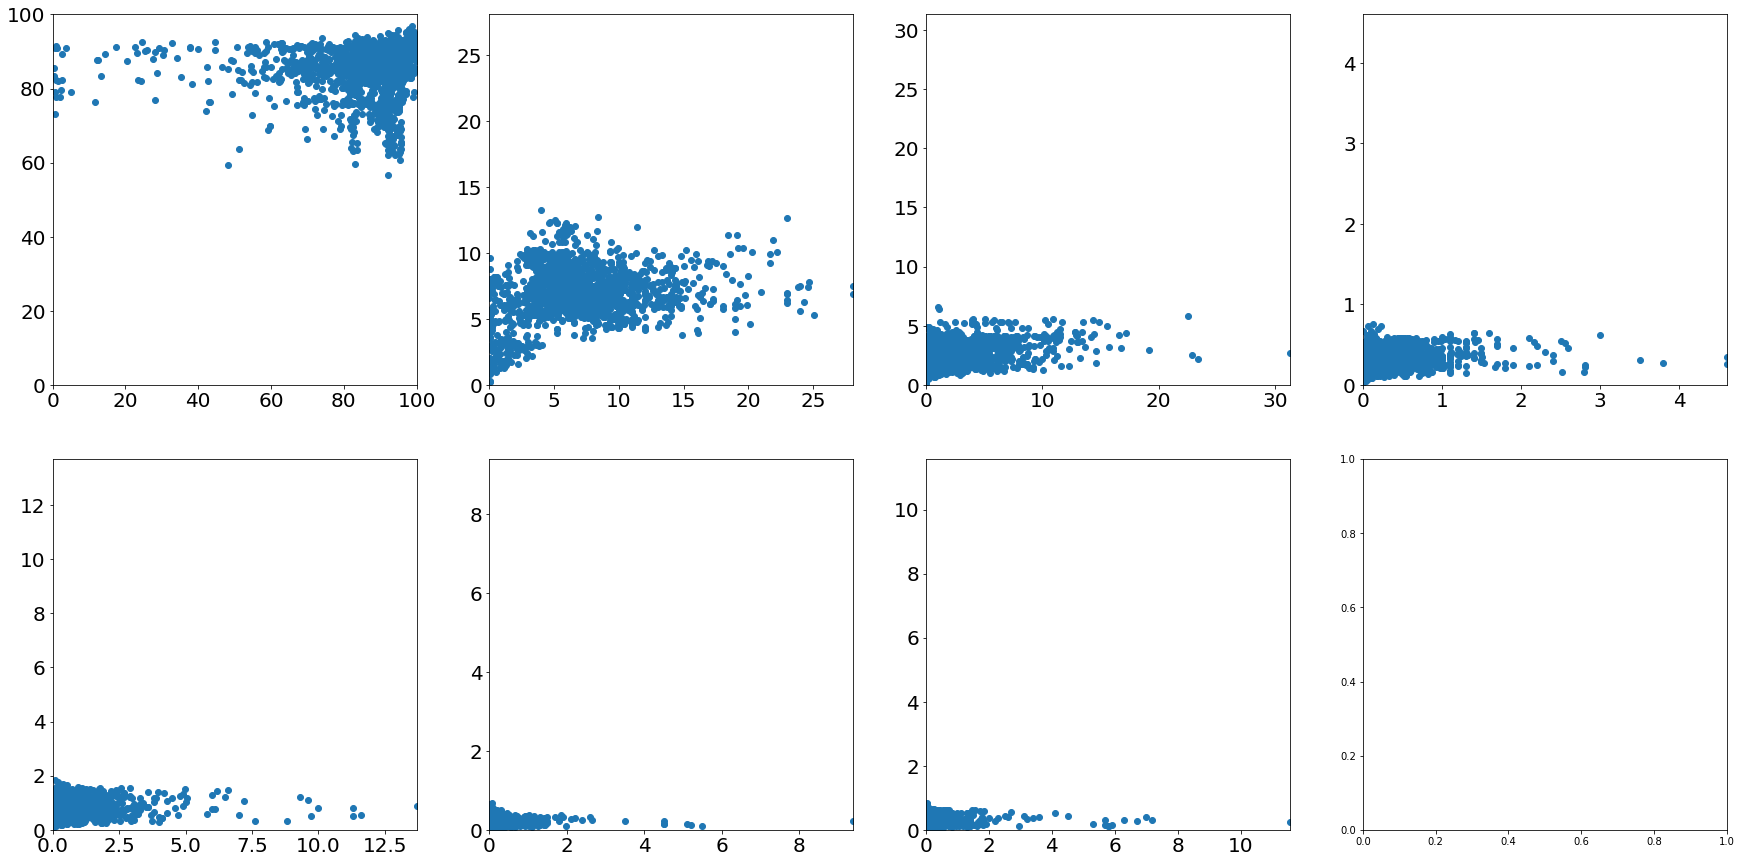

In [221]:
width = 4
height = 2
f, ax = plt.subplots(nrows = height, ncols = width, figsize=(30,15))
for i in range(7):
    ax[i//width, i % width].set_xlim(0, y_train.iloc[:, i].max())
    ax[i//width, i % width].set_ylim(0, y_train.iloc[:, i].max())
    ax[i//width, i % width].tick_params(labelsize = 20)
    ax[i//width, i % width].scatter(y_train.iloc[:, i], y_preds_neib.iloc[:, i])
#plt.savefig('Params_distributions.png')
plt.show()

## Clustering

In [29]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2, random_state=1)
X_pca = pca.fit_transform(X_scaled)

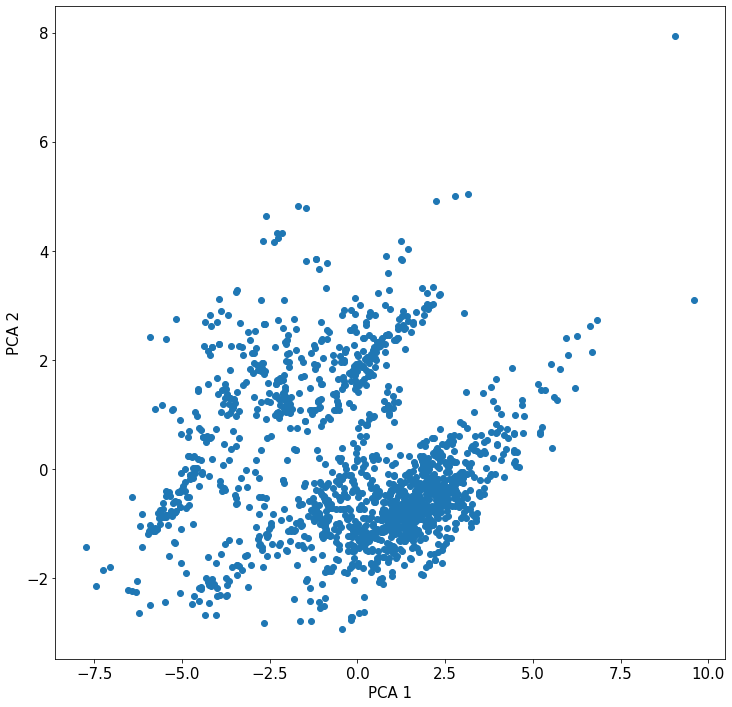

In [30]:
plt.figure(figsize=(12,12))
plt.xlabel('PCA 1', fontsize = 15)
plt.ylabel('PCA 2', fontsize = 15)
plt.tick_params(labelsize = 15)
plt.scatter(X_pca[:,0], X_pca[:,1])
#cond = y<20
#plt.scatter(X_pca[:,0][cond], X_pca[:,1][cond], c = 'red')
plt.show()

In [102]:
n_cls = 3
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
mix_t = GaussianMixture(n_components=n_cls, covariance_type='full', random_state=1, tol=1e-6, n_init=1, max_iter=1000)
#mix_t = KMeans(n_clusters = n_cls, n_jobs=-1)
#mix_t = AgglomerativeClustering(n_clusters = n_cls)
mix_t.fit(X_scaled)
y_clst = mix_t.predict(X_scaled)

In [103]:
y_preds = y_train.copy()
for i in range(y_train.shape[1]):
    print('FORECAST FOR NUMBER: ', i)
    y = y_train.iloc[:, i].copy()
    y_pred = y.copy()
    for cl in range(n_cls):
        print('Cluster', cl)
        XG_params, _ = optimal_params_search(xgb.XGBRegressor, XG_tune_params, X[y_clst == cl].copy(), y[y_clst == cl])

        scores = CV_estimator_with_sigma(xgb.XGBRegressor(**XG_params), X[y_clst == cl].copy(), y[y_clst == cl])

        y_pred[y_clst == cl] = cross_val_predict(xgb.XGBRegressor(**XG_params), X[y_clst == cl].copy(), y[y_clst == cl])
    y_preds.iloc[:, i] = y_pred
    print('r2', r2_score(y_train.iloc[:, i], y_preds.iloc[:, i]))
    print('-----------------------------')

FORECAST FOR NUMBER:  0
Cluster 0
Model gives R2: 0.190 +- 0.263
Model gives MAE: 12.654 +- 2.562
Model gives MSE: 332.569 +- 139.239
Cluster 1
Model gives R2: 0.584 +- 0.265
Model gives MAE: 4.096 +- 0.789
Model gives MSE: 69.407 +- 40.314
Cluster 2
Model gives R2: 0.370 +- 0.185
Model gives MAE: 5.623 +- 0.919
Model gives MSE: 86.398 +- 55.008
r2 -0.10315160201294771
-----------------------------
FORECAST FOR NUMBER:  1
Cluster 0
Model gives R2: 0.163 +- 0.129
Model gives MAE: 3.399 +- 0.836
Model gives MSE: 22.766 +- 11.168
Cluster 1
Model gives R2: 0.479 +- 0.109
Model gives MAE: 1.576 +- 0.175
Model gives MSE: 6.432 +- 1.858
Cluster 2
Model gives R2: 0.812 +- 0.102
Model gives MAE: 1.208 +- 0.169
Model gives MSE: 3.484 +- 1.577
r2 0.20418417023201774
-----------------------------
FORECAST FOR NUMBER:  2
Cluster 0
Model gives R2: 0.139 +- 0.144
Model gives MAE: 2.259 +- 0.468
Model gives MSE: 13.760 +- 8.907
Cluster 1
Model gives R2: 0.362 +- 0.109
Model gives MAE: 0.748 +- 0.133
M

In [99]:
X_train

,WH_LAT,WH_LONG,WH_TD_M,SH_DEPTH_TOP_FT,SH_DEPTH_BOT_FT,CSIA_CONC_C1,CSIA_NC1,CSIA_NC2,CSIA_NC3,CSIA_IC4,CSIA_NC4,CSIA_IC5,CSIA_NC5
29,56.736665,2.306140,4407.4082,9864.01,9885.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30,56.731516,2.324318,3971.8487,11558.01,11575.98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31,56.731516,2.324318,3971.8487,11652.00,11669.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32,56.808485,2.074547,5012.4358,9300.00,9320.00,NaN,-43.5,-29.4,NaN,NaN,NaN,NaN,NaN
33,56.808485,2.074547,5012.4358,9660.00,9700.00,NaN,-42.4,-29.6,-28.5,-29.5,-28.5,-28.2,-28.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1704,58.036853,-0.891146,2177.7959,6542.00,6542.00,NaN,-41.6,-27.9,-27.1,-28.8,-28.0,-28.3,-28.6
1705,58.036853,-0.891146,2177.7959,6542.00,6542.00,NaN,-41.5,-28.0,-27.2,-29.0,-28.1,-28.4,-28.8
1706,58.019424,-0.912446,2147.9256,6458.00,6508.00,NaN,-41.7,-28.2,-27.3,-29.2,-28.3,-28.5,-28.7
1707,58.367536,-0.081898,3116.5799,9447.01,9464.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [93]:
y_preds = y_train.copy()
for i in range(y_train.shape[1]):
    print('FORECAST FOR NUMBER: ', i)
    y = y_train.iloc[:, i].copy()
    y_pred = y.copy()
    
    XG_params, _ = optimal_params_search(xgb.XGBRegressor, XG_tune_params, X.copy(), y)

#     scores = CV_estimator_with_sigma(xgb.XGBRegressor(**XG_params), X.copy(), y)

    y_pred = cross_val_predict(xgb.XGBRegressor(**XG_params), X.copy(), y)
    print('r2', r2_score(y_train.iloc[:, i], y_pred))
    print('-----------------------------')

FORECAST FOR NUMBER:  0
r2 0.03194118599542428
-----------------------------
FORECAST FOR NUMBER:  1
r2 0.13869369962043798
-----------------------------
FORECAST FOR NUMBER:  2
r2 -0.04050932756480563
-----------------------------
FORECAST FOR NUMBER:  3
r2 -0.0055708799073672655
-----------------------------
FORECAST FOR NUMBER:  4
r2 0.08631756645623845
-----------------------------
FORECAST FOR NUMBER:  5
r2 -0.12645119511825365
-----------------------------
FORECAST FOR NUMBER:  6
r2 -0.07914292219615682
-----------------------------


FORECAST FOR NUMBER:  0


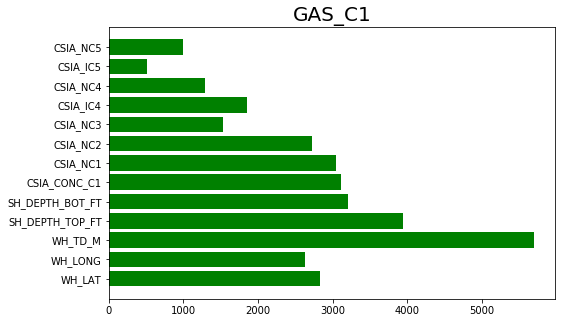

-----------------------------
FORECAST FOR NUMBER:  1


<Figure size 432x288 with 0 Axes>

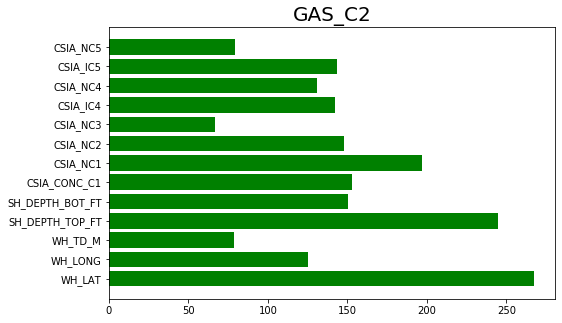

-----------------------------
FORECAST FOR NUMBER:  2


<Figure size 432x288 with 0 Axes>

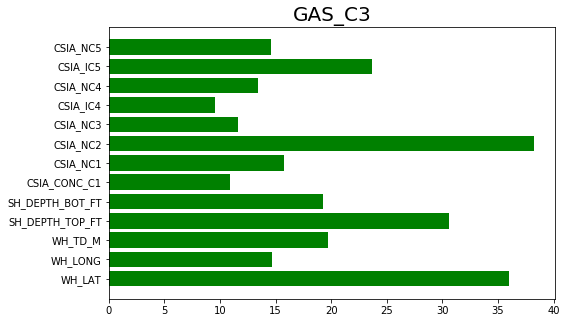

-----------------------------
FORECAST FOR NUMBER:  3


<Figure size 432x288 with 0 Axes>

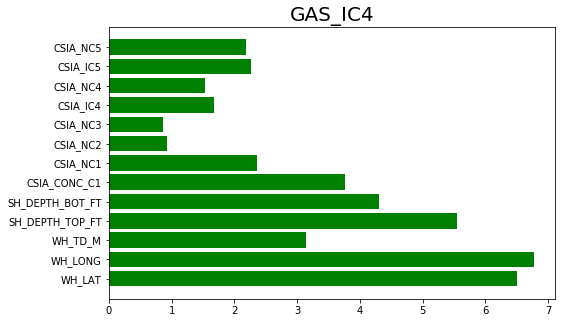

-----------------------------
FORECAST FOR NUMBER:  4


<Figure size 432x288 with 0 Axes>

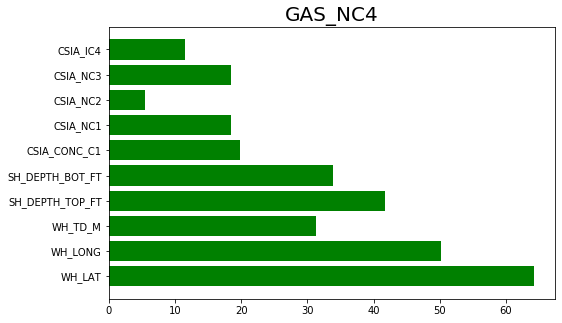

-----------------------------
FORECAST FOR NUMBER:  5


<Figure size 432x288 with 0 Axes>

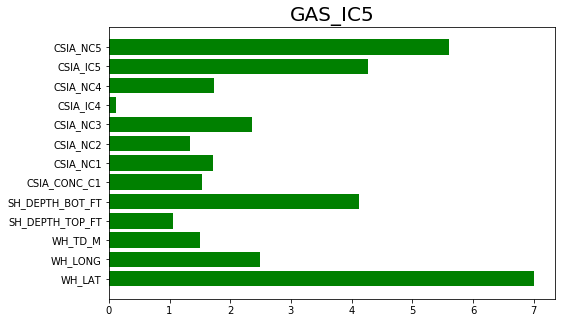

-----------------------------
FORECAST FOR NUMBER:  6


<Figure size 432x288 with 0 Axes>

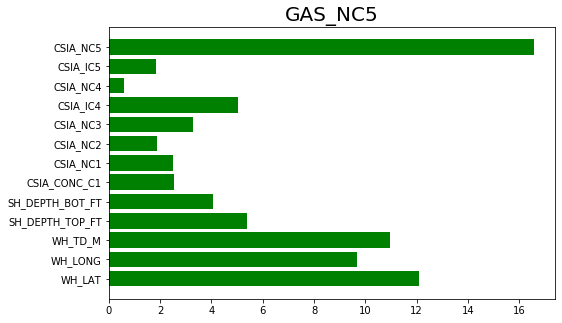

-----------------------------


<Figure size 432x288 with 0 Axes>

In [81]:
y_preds = y_train.copy()
target_names = ['GAS_C1', 'GAS_C2', 'GAS_C3', 'GAS_IC4', 'GAS_NC4', 'GAS_IC5', 'GAS_NC5']

for i in range(y_train.shape[1]):
    print('FORECAST FOR NUMBER: ', i)
    y = y_train.iloc[:, i].copy()
    y_pred = y.copy()
    XG_params, _ = optimal_params_search(xgb.XGBRegressor, XG_tune_params, X.copy(), y)

#     scores = CV_estimator_with_sigma(xgb.XGBRegressor(**XG_params), X.copy(), y)
    regr = xgb.XGBRegressor(**XG_params).fit(X.copy(), y)
#     # importance_type = ['weight', 'gain', 'cover', 'total_gain', 'total_cover']
    feat_imp = regr.get_booster().get_score(importance_type = 'gain').values()
    plt.figure(figsize=(8, 5))
    plt.yticks(np.arange(len(feat_imp)), X_train.columns.values, rotation ='horizontal')
    plt.barh(np.arange(len(feat_imp)), feat_imp, color = 'green')
    plt.title(target_names[i], fontsize = 20)
    plt.show()
    plt.tight_layout()
#     y_pred = regr.predict(X_test_filled)
#     df_test[target_names[i]] = y_pred
#     plt.savefig('feature_imp_)
    
#     y_pred = cross_val_predict(xgb.XGBRegressor(**XG_params), X.copy(), y)
    
#     y_preds.iloc[:, i] = y_pred
    
    print('-----------------------------')

In [80]:
df_test.to_csv('final_result.csv')

In [36]:
def NRMSE_metric(y_true, y_pred):
    result = np.sqrt(mean_squared_error(y_true, y_pred) / mean_squared_error(y_true, np.zeros(y_true.shape[0])))
    return result

In [56]:
for i in range(7):
    print(r2_score(y_train.iloc[:, i], y_preds[y_clst == j].iloc[:, i]))

0.17874903087285765
0.5492682295651123
0.3020888913639306
0.1415193375941599
0.10287897049073613
0.06287229248891868
-0.07549618869539443


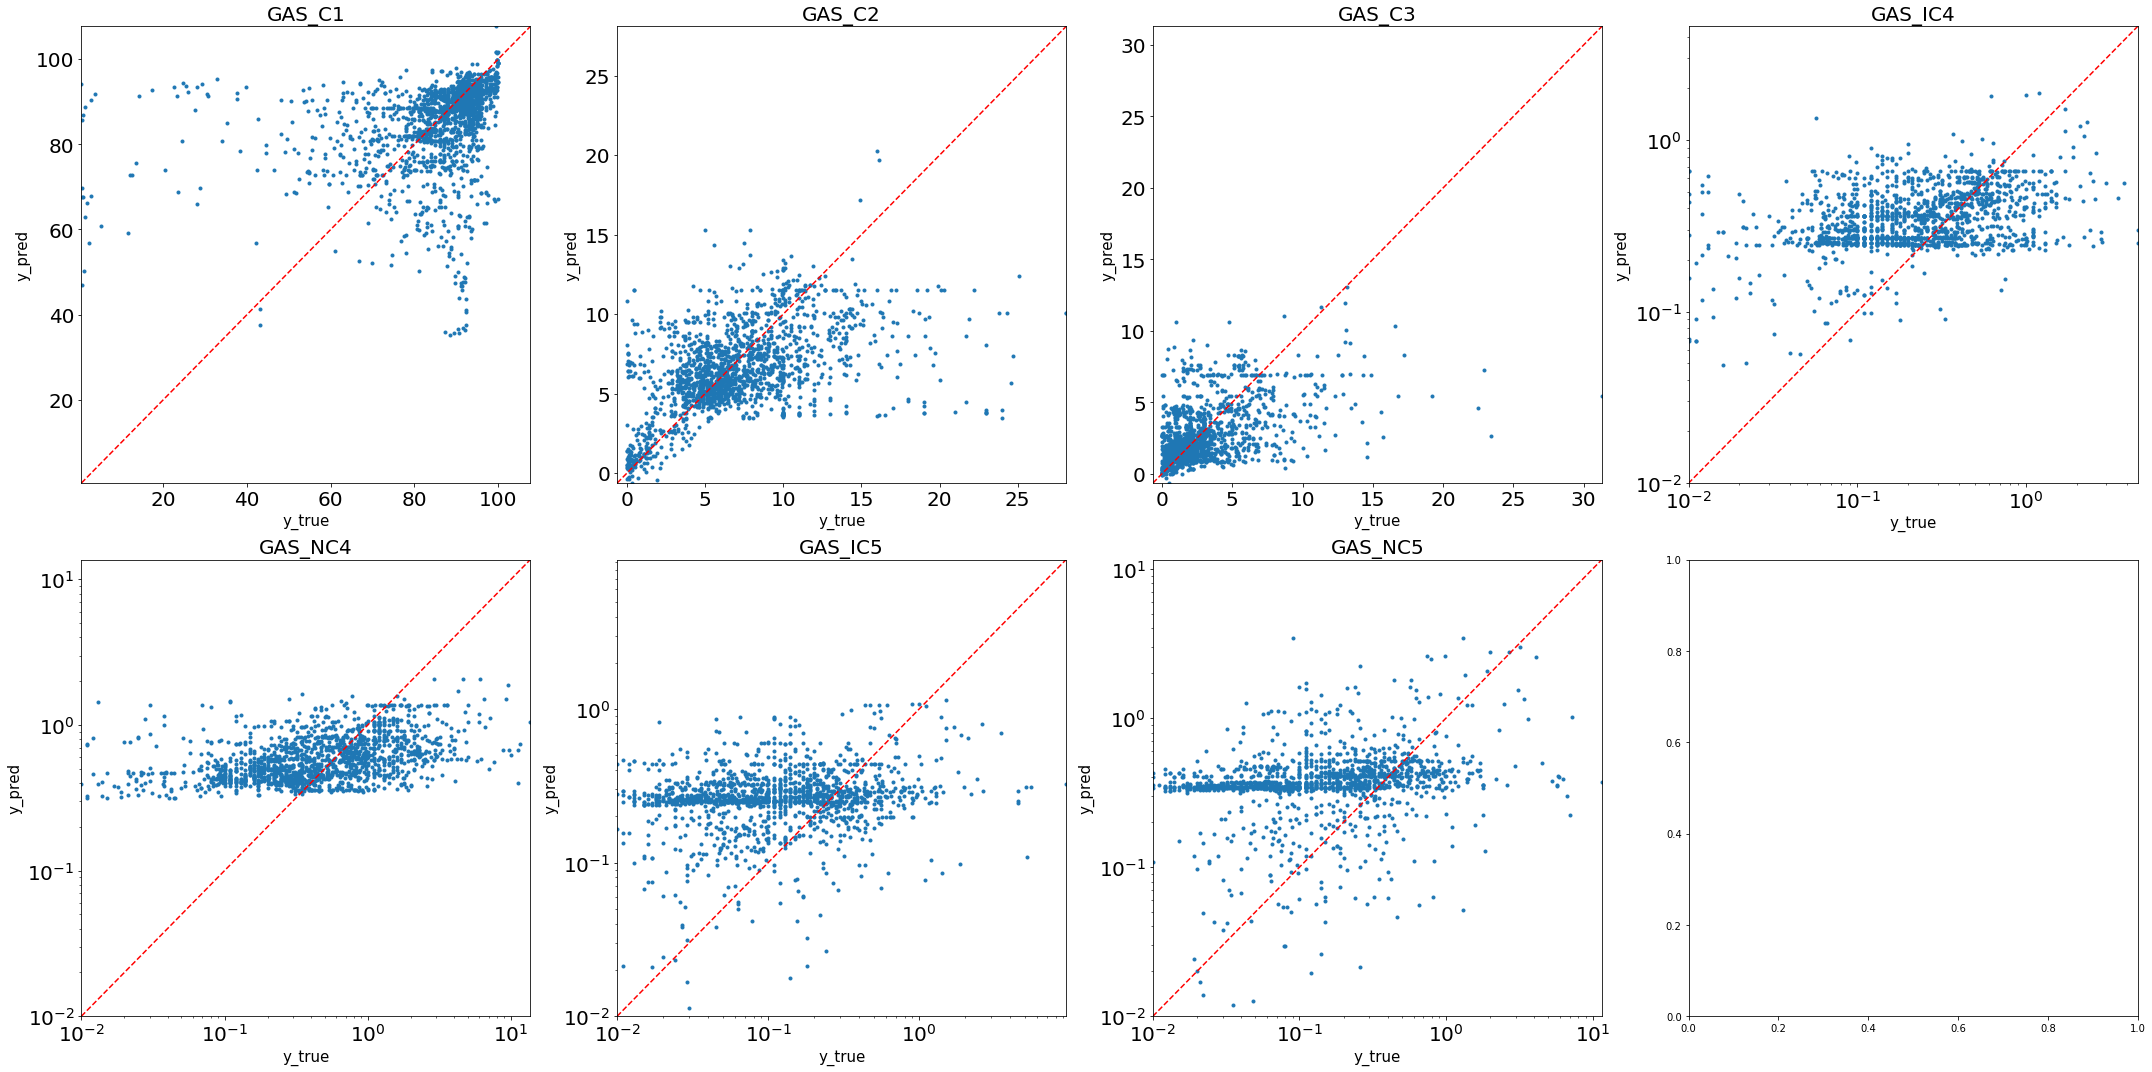

In [48]:
height = 2
width = 4

f, ax = plt.subplots(nrows = height, ncols = width, figsize=(30, 15))

target_names = ['GAS_C1', 'GAS_C2', 'GAS_C3', 'GAS_IC4', 'GAS_NC4', 'GAS_IC5', 'GAS_NC5']

for i in range(7):
    ax[i//width, i % width].tick_params(labelsize = 20)
    ax[i//width, i % width].plot(y_train.iloc[:, i], y_preds.iloc[:, i], linestyle = '', \
                                marker = 'o', markersize = 3)
    
    minimal_value = np.min([y_train.iloc[:, i].min(), y_preds.iloc[:, i].min()])
    maximum_value = np.max([y_train.iloc[:, i].max(), y_preds.iloc[:, i].max()])
    
    if minimal_value < 0:
        mininimal_value = 1e-3

    
    if i >= 3:
        ax[i//width, i % width].set_xscale('log')
        ax[i//width, i % width].set_yscale('log')
        ax[i//width, i % width].set_xlim(1e-2, maximum_value)
        ax[i//width, i % width].set_ylim(1e-2, maximum_value)
#         print(mininimal_value, maximum_value)
    else:
        ax[i//width, i % width].set_xlim(minimal_value, maximum_value)
        ax[i//width, i % width].set_ylim(minimal_value, maximum_value)


    ax[i//width, i % width].plot([minimal_value, maximum_value], [minimal_value, maximum_value], \
                                 color = 'red', linestyle = '--')
    ax[i//width, i % width].set_title(target_names[i], fontsize = 20)
    ax[i//width, i % width].set_xlabel('y_true', fontsize = 15)
    ax[i//width, i % width].set_ylabel('y_pred', fontsize = 15)
#     ax[i//width, i % width].legend(fontsize = 20)
plt.tight_layout()

# plt.show()
plt.savefig('part_1_results_all.png')

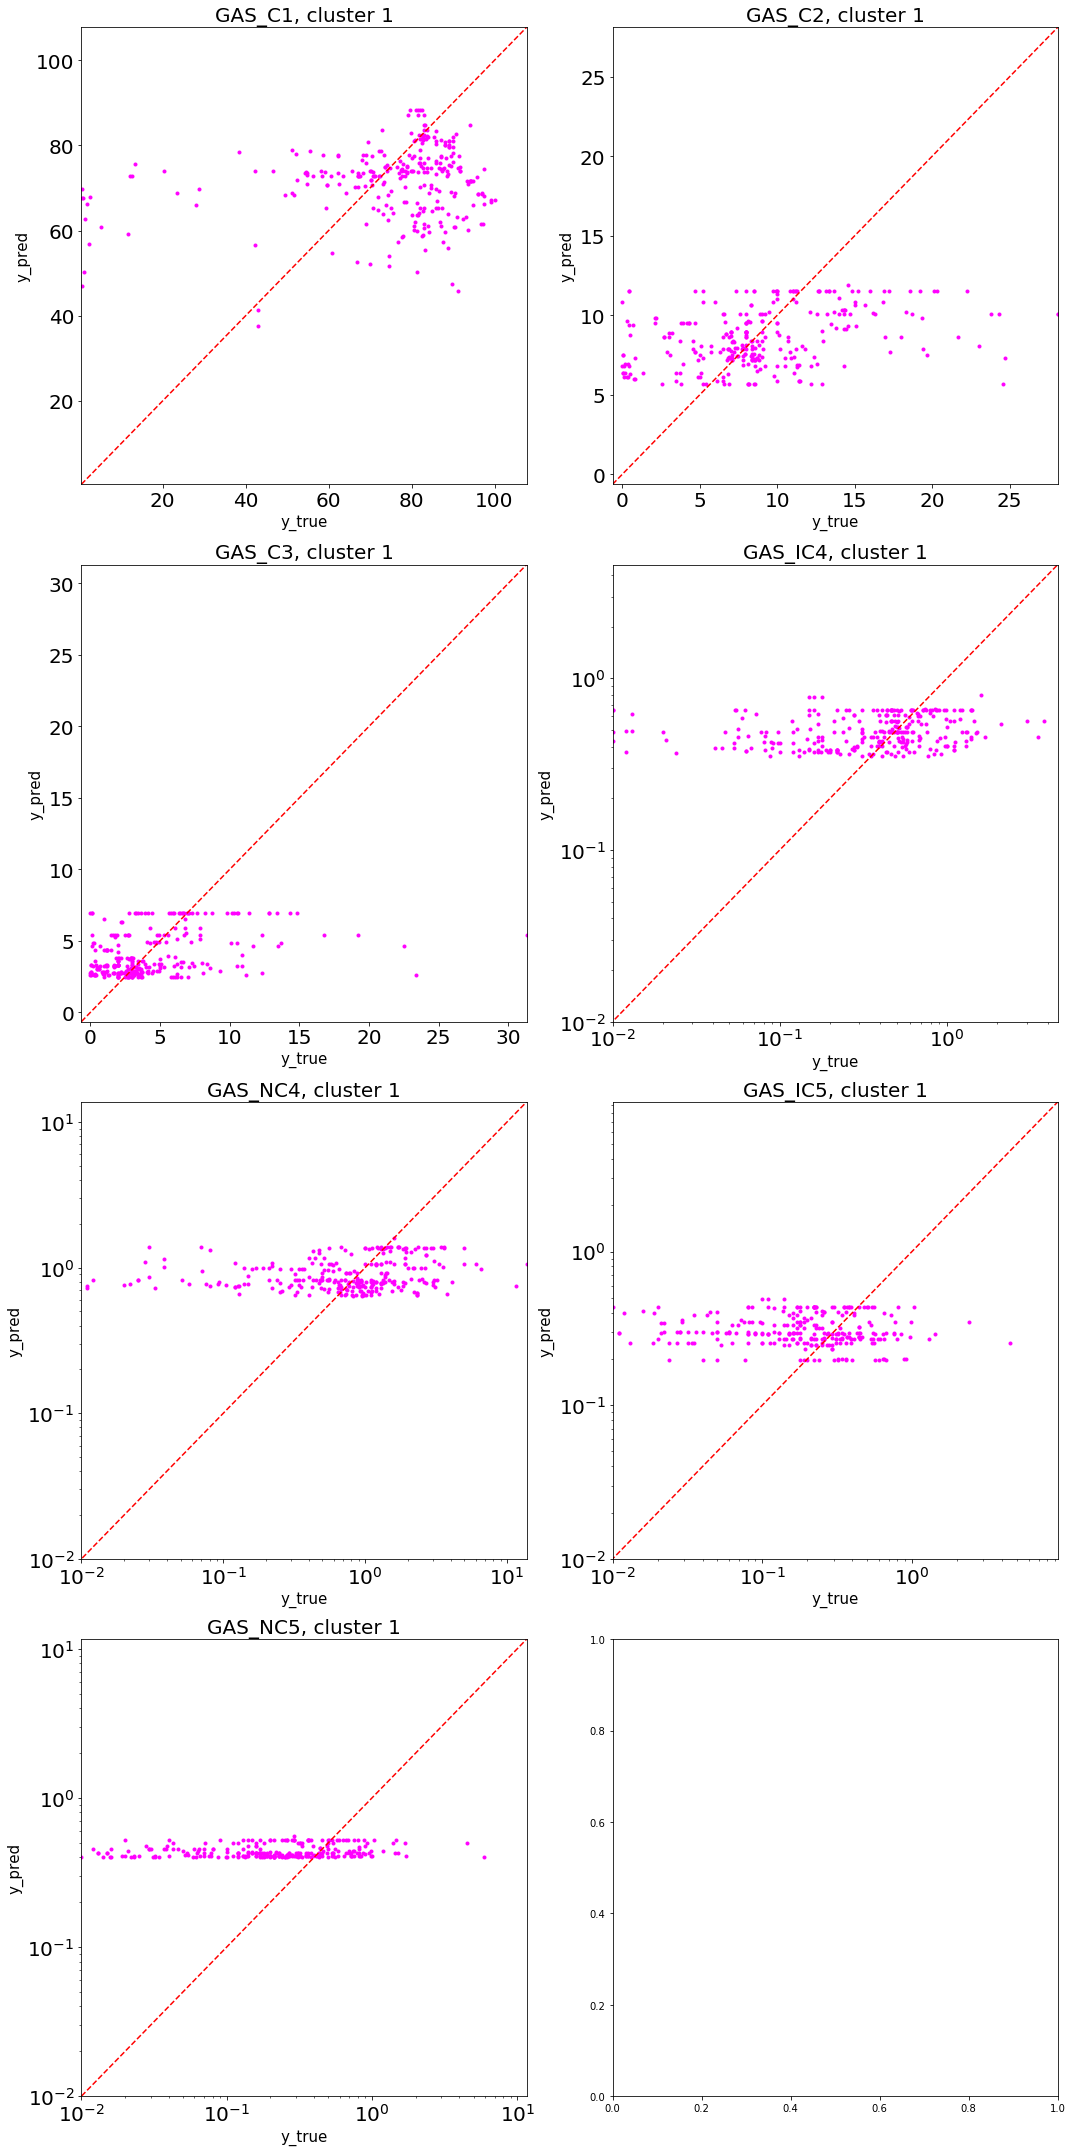

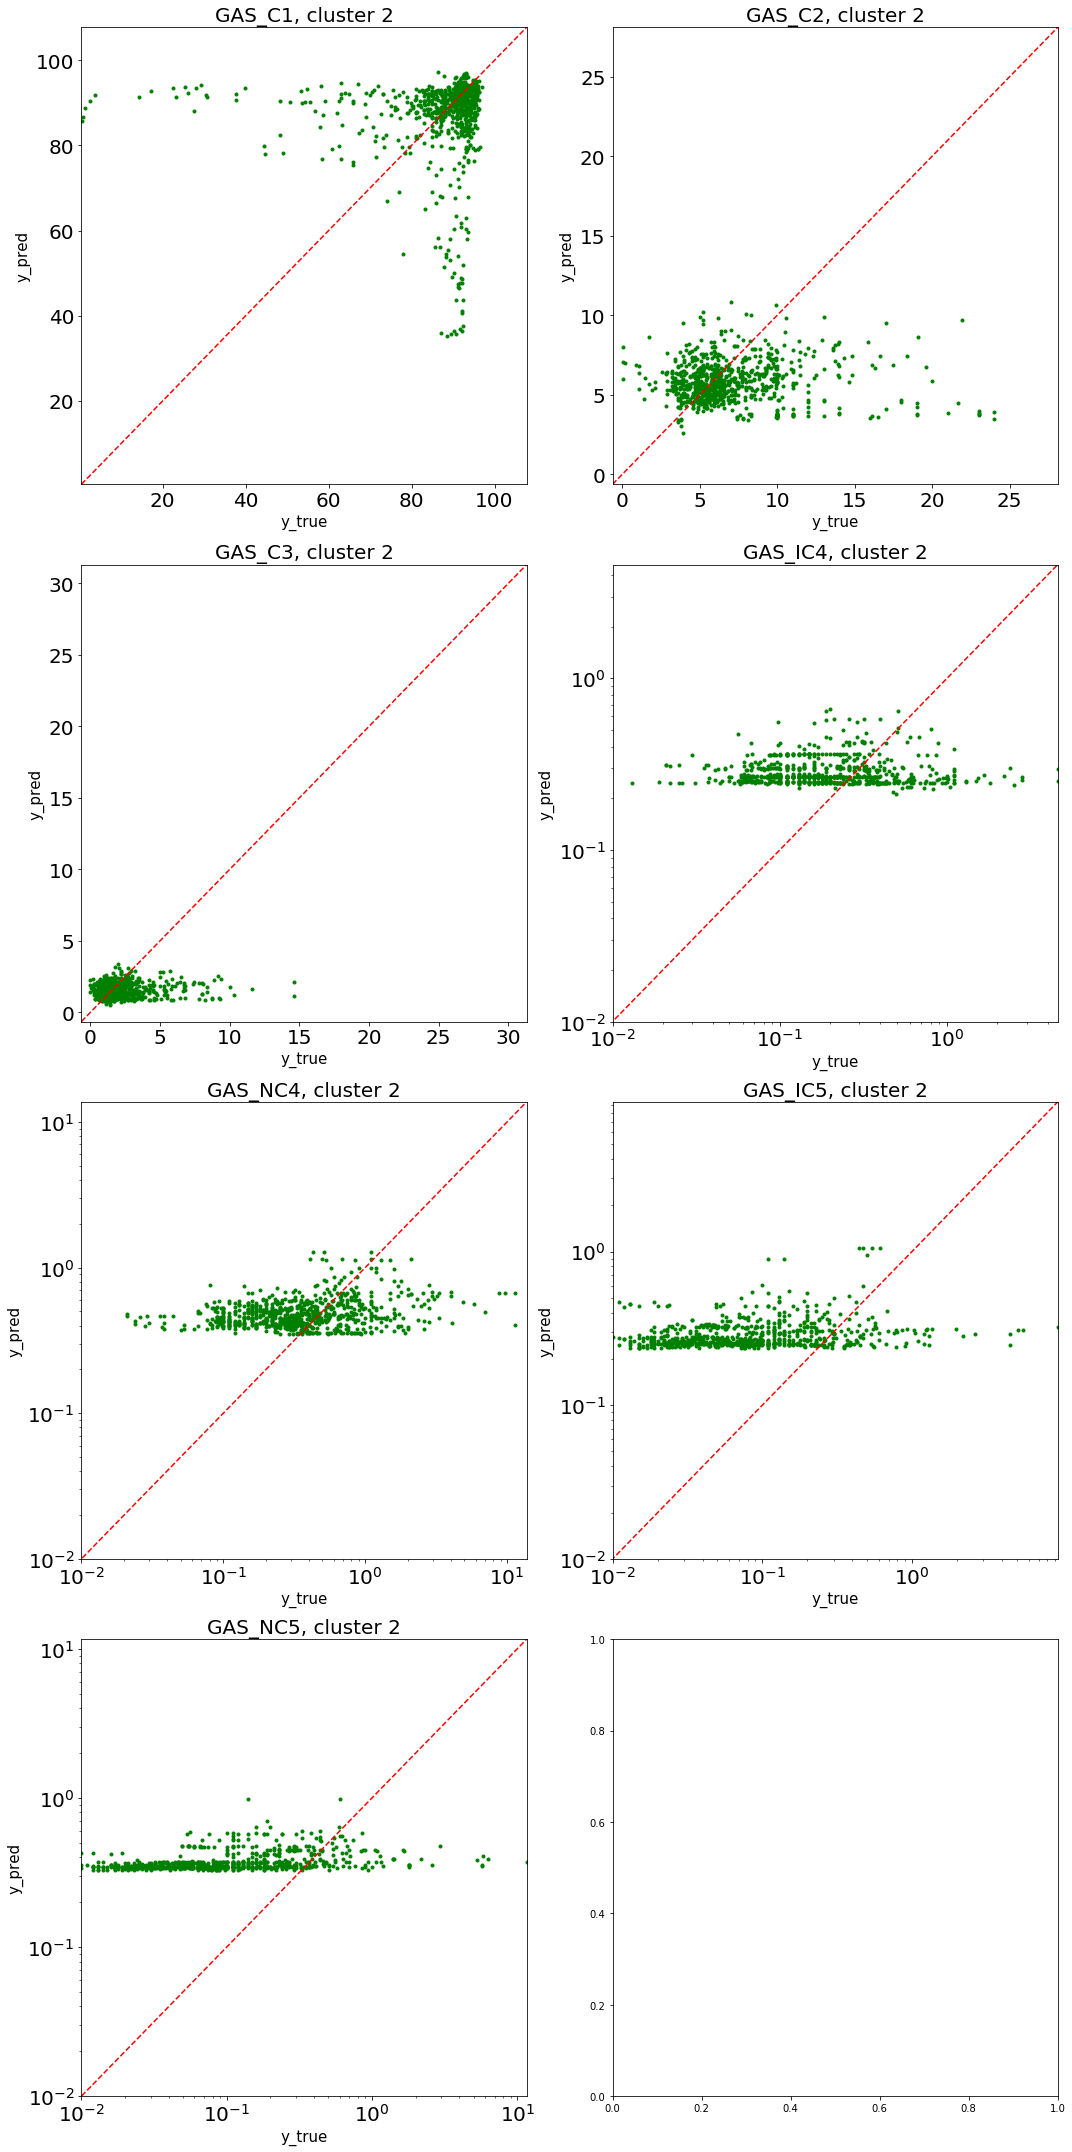

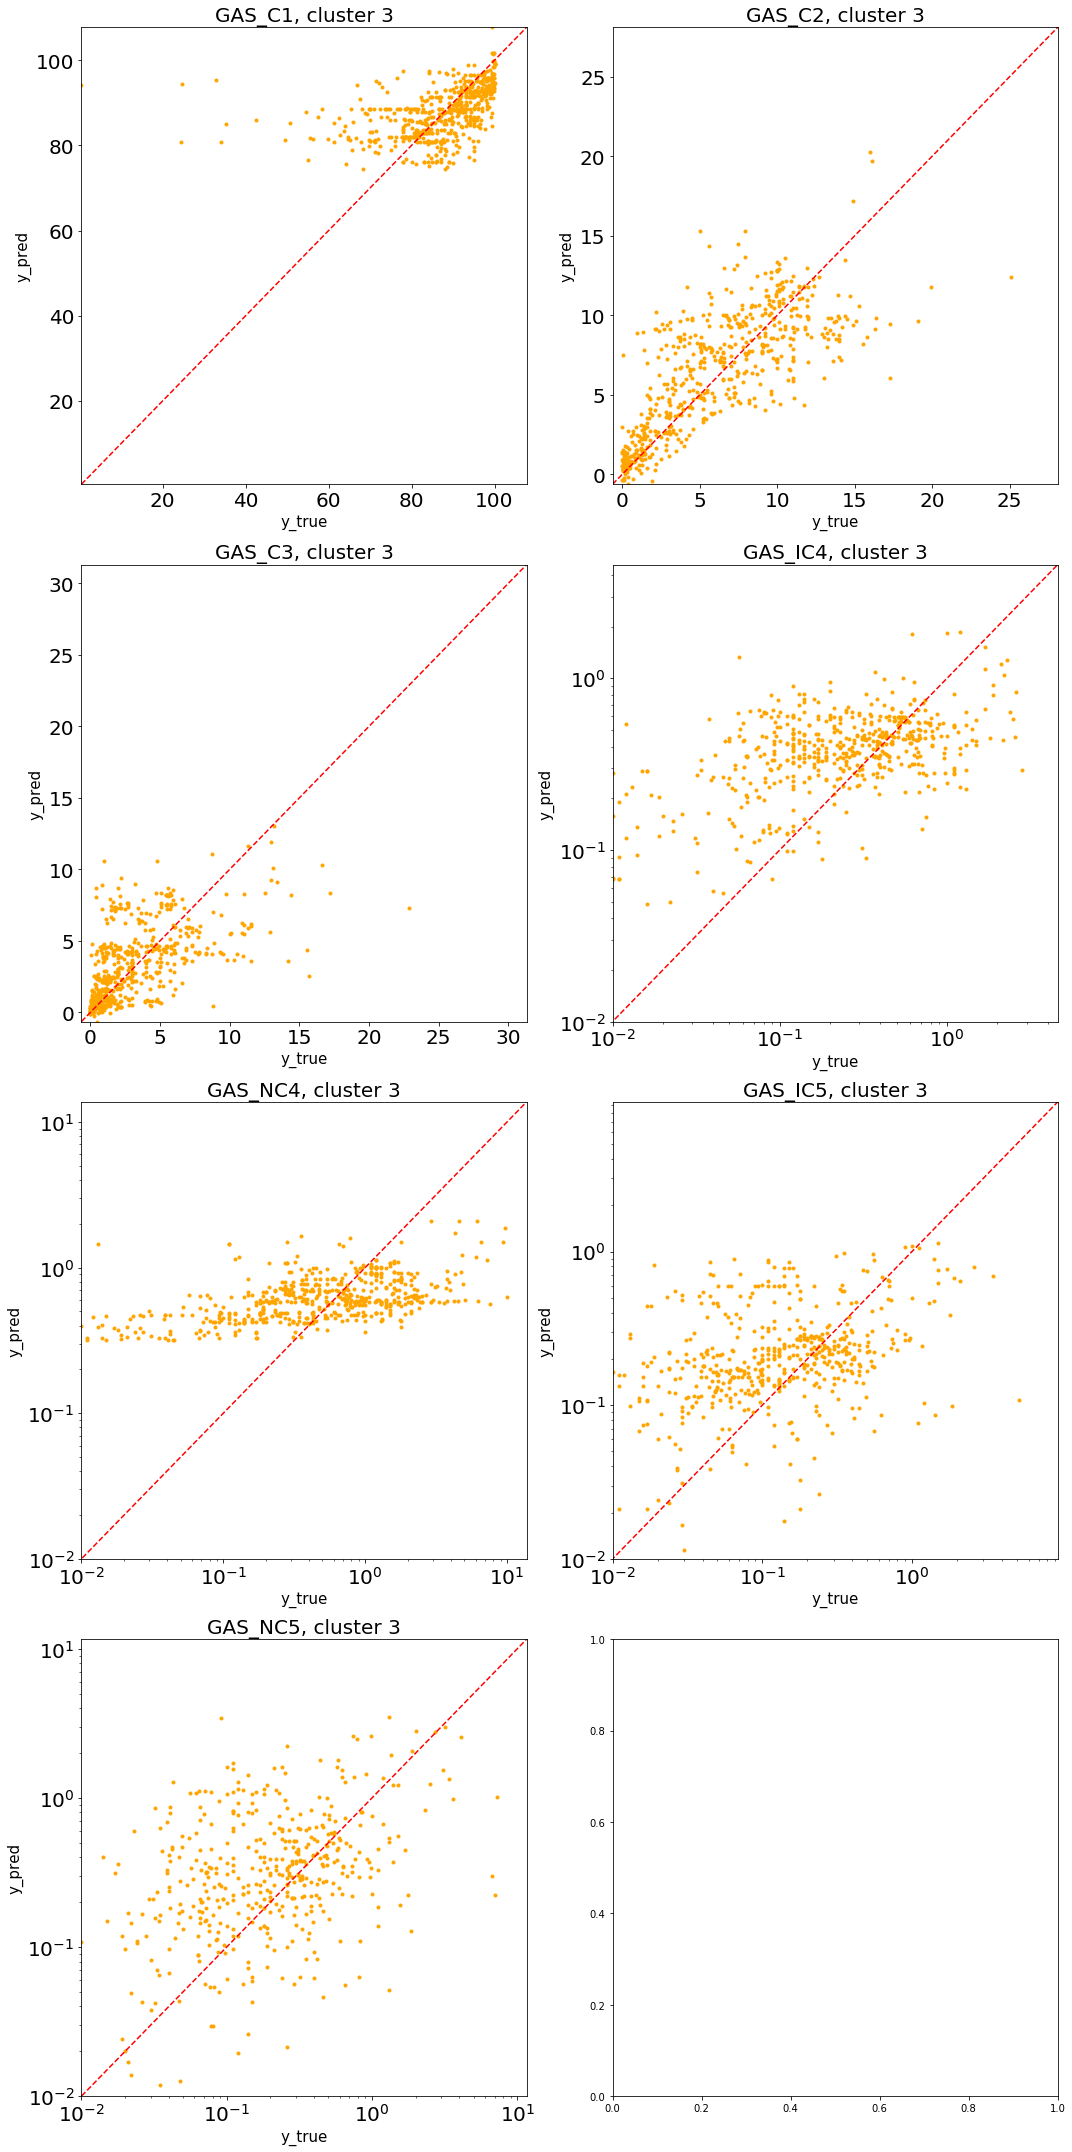

In [207]:
height = 4
width = 2

list_color = ['magenta', 'green', 'orange']

for j in range(n_cls):
    f, ax = plt.subplots(nrows = height, ncols = width, figsize=(15, 30))
    for i in range(7):
        ax[i//width, i % width].tick_params(labelsize = 20)
        ax[i//width, i % width].plot(y_train[y_clst == j].iloc[:, i], y_preds[y_clst == j].iloc[:, i], linestyle = '', \
                                    marker = 'o', markersize = 3, color = list_color[j])
        minimal_value = np.min([y_train.iloc[:, i].min(), y_preds.iloc[:, i].min()])
        maximum_value = np.max([y_train.iloc[:, i].max(), y_preds.iloc[:, i].max()])

        if minimal_value < 0:
            mininimal_value = 1e-3

        if i >= 3:
            ax[i//width, i % width].set_xscale('log')
            ax[i//width, i % width].set_yscale('log')
            ax[i//width, i % width].set_xlim(1e-2, maximum_value)
            ax[i//width, i % width].set_ylim(1e-2, maximum_value)
    #         print(mininimal_value, maximum_value)
        else:
            ax[i//width, i % width].set_xlim(minimal_value, maximum_value)
            ax[i//width, i % width].set_ylim(minimal_value, maximum_value)


        ax[i//width, i % width].plot([minimal_value, maximum_value], [minimal_value, maximum_value], color = 'red', \
                                    linestyle = '--')
        ax[i//width, i % width].set_title(target_names[i] + ', cluster ' + str(j+1), fontsize = 20)
        ax[i//width, i % width].set_xlabel('y_true', fontsize = 15)
        ax[i//width, i % width].set_ylabel('y_pred', fontsize = 15)
    plt.tight_layout()
    # plt.show()
    plt.savefig('part_'+str(j)+'_results_clusters.png')

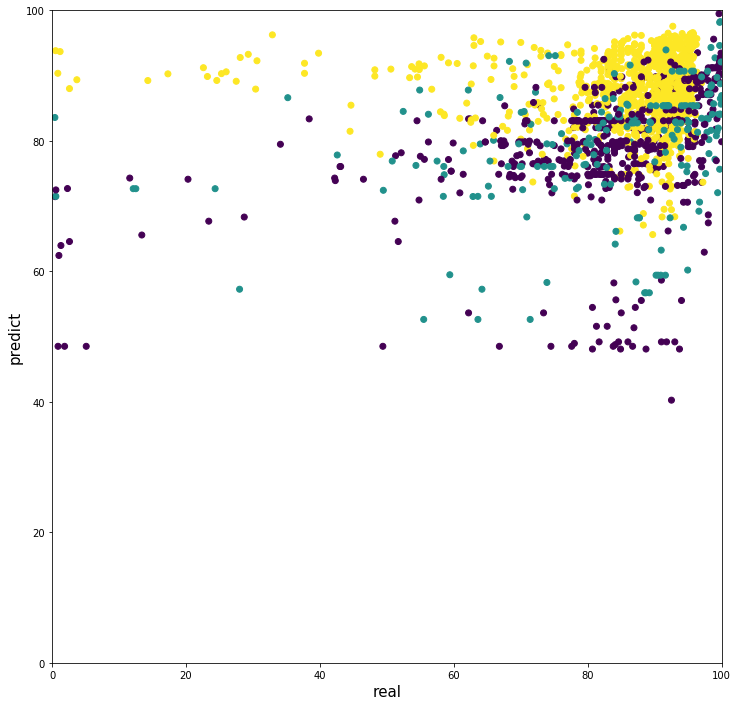

In [236]:
plt.figure(figsize=(12,12))
plt.xlabel('real', fontsize = 15)
plt.ylabel('predict', fontsize = 15)
plt.scatter(y, y_pred_0, c = y_clst)
plt.xlim(0,100)
plt.ylim(0,100)
plt.show()

## Outlier detection

In [158]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [241]:
i = 2
y_pred_0 = y_preds.iloc[:, i]
y = y_train.iloc[:, i]

In [242]:
result = 1
pred_accur = 0
out_manual = np.ones(y.shape[0])
out_manual[np.abs(y_pred_0 - y) / y > 0.5] = 0
print((np.abs(y_pred_0 - y) / y > 0.5).sum() / y.shape[0])

0.5071428571428571


In [243]:
f1_score_list = []
for i in range(1, 101, 2):
    clf_outl = LocalOutlierFactor(n_neighbors = i, contamination = 0.5, n_jobs = -1)
    y_pred_outlier = clf_outl.fit_predict(X_scaled)
    y_pred_outlier[y_pred_outlier == -1] = 0
    cur_accur = f1_score(out_manual, y_pred_outlier)
    f1_score_list.append(cur_accur)
#     print(cur_accur)
    if cur_accur > pred_accur:
        result = i
        pred_accur = cur_accur
print(result, cur_accur)

79 0.5467625899280575


In [244]:
clf_outl = LocalOutlierFactor(n_neighbors = 79, contamination = 0.5, n_jobs = -1)
y_pred_outlier = clf_outl.fit_predict(X_scaled)
y_pred_outlier[y_pred_outlier == -1] = 0

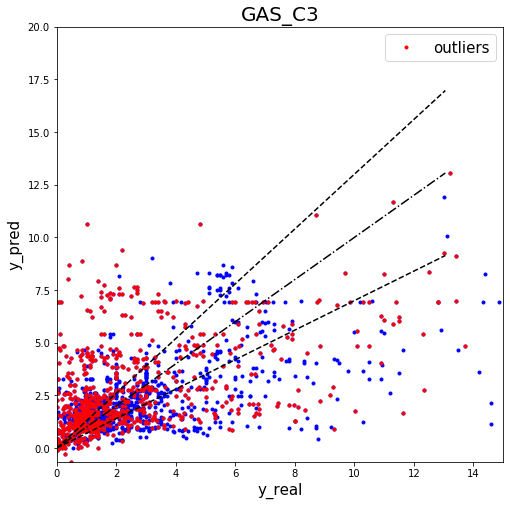

In [252]:
plt.figure(figsize=(8,8))
plt.xlabel('y_real', fontsize = 15)
plt.ylabel('y_pred', fontsize = 15)
plt.plot(y, y_pred_0, linestyle = '', marker = 'o', markersize = 3, color = 'blue')
plt.plot(y[y_pred_outlier == 0], y_pred_0[y_pred_outlier == 0], linestyle = '', marker = 'o', markersize = 3, \
        color = 'red', label = 'outliers')
plt.plot([y_pred_0.min(), y_pred_0.max()], [y_pred_0.min(), y_pred_0.max()], color = 'black', linestyle = '-.')
plt.plot([0, y_pred_0.max()], [0, y_pred_0.max()*1.3], color = 'black', linestyle = '--')
plt.plot([0, y_pred_0.max()], [0, y_pred_0.max()*0.7], color = 'black', linestyle = '--')
plt.xlim(0, 15)
plt.ylim(y_pred_0.min(), 20)
plt.legend(fontsize = 15)
plt.title(target_names[2], fontsize = 20)
# plt.scatter(y, y_pred_0, c = y_pred_outlier)
# plt.xlim(0,100)
# plt.ylim(0,100)
plt.show()

In [238]:
result_1 = 1
result_2 = 0.1
pred_accur = 0

for i in np.linspace(1, 20, 10, dtype = 'int'):
    for j in np.linspace(0.1, 1, 9):
        clf_outl = IsolationForest(n_estimators = i, max_samples = j, contamination = 0.3, \
                                   bootstrap = True, n_jobs = -1, behaviour = 'new', random_state = 0)
        y_pred_out = clf_outl.fit_predict(X)
        cur_accur = f1_score(out_manual, y_pred_outlier)
        if cur_accur > pred_accur:
            result_1 = i
            result_2 = j
            pred_accur = cur_accur
print(result_1, result_2, cur_accur)

1 0.1 0.7642886942010847


In [239]:
clf_outl = IsolationForest(n_estimators = 1, max_samples = 0.1, contamination = 0.3, \
                                   bootstrap = True, n_jobs = -1, behaviour = 'new', random_state = 0)
y_pred_outlier = clf_outl.fit_predict(X)
y_pred_outlier[y_pred_outlier == -1] = 0

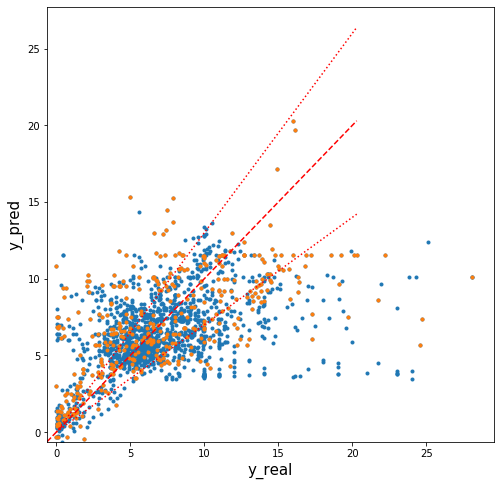

In [240]:
plt.figure(figsize=(8,8))
plt.xlabel('y_real', fontsize = 15)
plt.ylabel('y_pred', fontsize = 15)
plt.plot(y, y_pred_0, linestyle = '', marker = 'o', markersize = 3)
plt.plot(y[y_pred_outlier == 0], y_pred_0[y_pred_outlier == 0], linestyle = '', marker = 'o', markersize = 3)
plt.plot([y_pred_0.min(), y_pred_0.max()], [y_pred_0.min(), y_pred_0.max()], color = 'red', linestyle = '--')
plt.plot([0, y_pred_0.max()], [0, y_pred_0.max()*1.3], color = 'red', linestyle = ':')
plt.plot([0, y_pred_0.max()], [0, y_pred_0.max()*0.7], color = 'red', linestyle = ':')
plt.xlim(y_pred_0.min(), )
plt.ylim(y_pred_0.min(), )
# plt.scatter(y, y_pred_0, c = y_pred_outlier)
# plt.xlim(0,100)
# plt.ylim(0,100)
plt.show()

In [130]:
def box_plots(df):
    cols = []
    for i,col in enumerate(df.columns):
        if isinstance(df[col].values[0], (int, float)) and df[col].unique().shape[0] > 10:
            cols.append(col)    
    width = int(np.floor(np.sqrt(len(cols))))
    height = len(cols) // width 
    if len(cols) % width != 0:
        height += 1
    f, ax = plt.subplots(nrows = height, ncols = width,figsize=(30,30))
    for i, col in enumerate(cols):
        df.boxplot([col], ax = ax[i//width, i % width], fontsize = 14)
    plt.show()

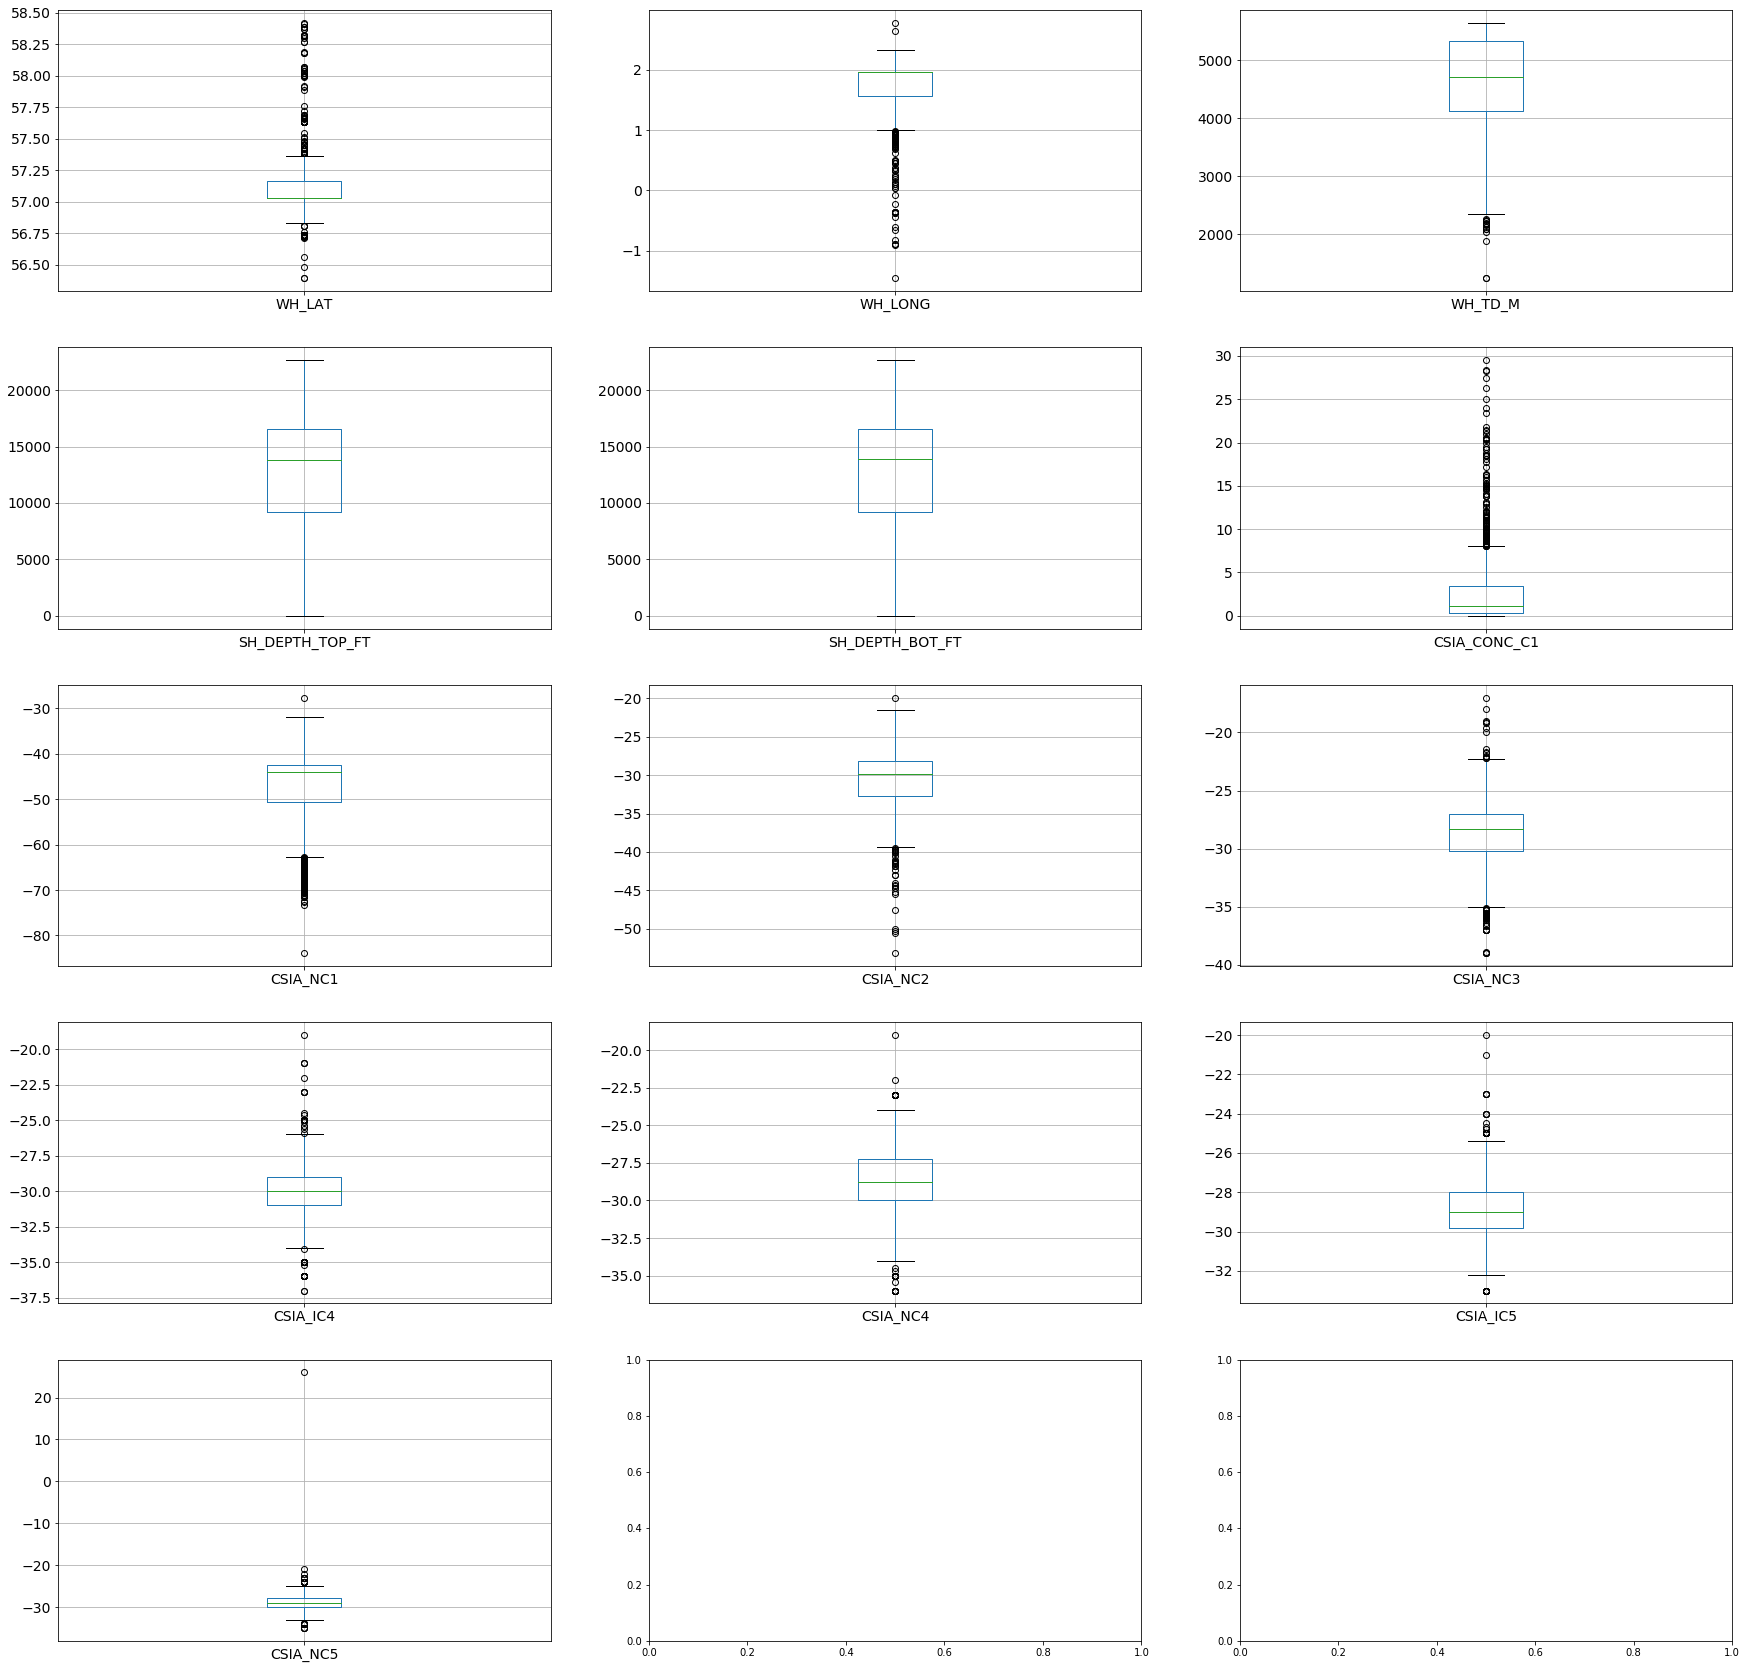

In [131]:
box_plots(X)

In [ ]:
pca.explained_variance_ratio_

In [ ]:
n_components = np.arange(1, 15)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(X_pca)
          for n in n_components]

plt.plot(n_components, [m.bic(X_pca) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X_pca) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')

In [ ]:
n_cls = 3
mix_t = GaussianMixture(n_components=n_cls, covariance_type='full', random_state=1, tol=1e-6, n_init=1, max_iter=1000)
mix_t = KMeans(n_clusters = n_cls, n_jobs=-1)
#mix_t = AgglomerativeClustering(n_clusters = n_cls)
mix_t.fit(X)

In [ ]:
y_clst = mix_t.predict(X)

In [ ]:
plt.figure(figsize=(12,12))
plt.xlabel('PCA 1', fontsize = 15)
plt.ylabel('PCA 2', fontsize = 15)
plt.tick_params(labelsize = 15)
sc = plt.scatter(X_pca[:,0], X_pca[:,1], c = y_clst, cmap = 'viridis')
plt.colorbar(sc)
plt.show()

In [ ]:
width = 4
height = 2
f, ax = plt.subplots(nrows = height, ncols = width, figsize=(30,15))
for i in range(7):
    ax[i//width, i % width].set_xlim(0, y_train.iloc[:, i].max())
    ax[i//width, i % width].set_ylim(0, y_train.iloc[:, i].max())
    ax[i//width, i % width].tick_params(labelsize = 20)
    ax[i//width, i % width].scatter(y_train.iloc[:, i], y_preds.iloc[:, i],  c = y_clst)
    
    #df[df[col] !=0].hist([col], ax = ax[i//width, i % width], bins = 100)
    #ax[i//width, i % width].title.set_size(18)
#plt.savefig('Params_distributions.png')
plt.show()

In [ ]:
# X = X_train_filled.copy()
# rankings = []
# params = []
# r2_s = [None]*7
# mae_s = [None]*7
# mse_s = [None]*7
# std_r2_s = [None]*7
# std_mae_s = [None]*7
# std_mse_s = [None]*7
# y_preds = y_train.copy()
# for i in range(y_train.shape[1]):
#     print('FORECAST: ', i)
#     y = y_train.iloc[:, i].copy()
#     estimator = xgb.XGBRegressor(objective = 'reg:squarederror', n_estimators=300,
#                              subsample=0.75, random_state = 1)
#     selector_XG = RFECV(estimator, step=1, cv=4, scoring = 'neg_mean_absolute_error')
#     selector_XG = selector_XG.fit(X, y)
#     ranking_df = pd.DataFrame({'Feature': X.columns.to_list(), 'XGB ranks':selector_XG.ranking_},
#                           index = X.columns.to_list())
#     ranking_df.sort_values(by = 'XGB ranks', inplace=True, ascending = True)
#     rankings.append(ranking_df)
#     best_r2 = 0
#     for j in range(8, ranking_df['Feature'].shape[0]+1, 1):
#         print('Features used', j)
#         XG_params, _ = optimal_params_search(xgb.XGBRegressor, XG_tune_params, X[ranking_df['Feature'].to_list()[:j]],
#                                              y, verbose = False, scoring='r2')
#         scores = CV_estimator_with_sigma(xgb.XGBRegressor(**XG_params), X[ranking_df['Feature'].to_list()[:j]], y)
#         if scores['test_r2'].mean() > best_r2:
#             best_r2 = scores['test_r2'].mean()
#             params = XG_params
#             y_preds.iloc[:, i] = cross_val_predict(xgb.XGBRegressor(**XG_params), X[ranking_df['Feature'].to_list()[:j]], y)
#             r2_s[i] = scores['test_r2'].mean()
#             mae_s[i] = abs(scores['test_mae']).mean()
#             mse_s[i] = abs(scores['test_mse']).mean()
#             std_r2_s[i] = 2*scores['test_r2'].std()
#             std_mae_s[i] = 2*abs(scores['test_mae']).std()
#             std_mse_s[i] = 2*abs(scores['test_mse']).std()

In [ ]:
y_pred = cross_val_predict(xgb.XGBRegressor(**params[0]), X_train, y_train.iloc[:, 3], cv  = 5)

In [ ]:
cross_val_score(xgb.XGBRegressor(**params[0]), X_train, y_train.iloc[:, 3], cv  = 5, scoring = 'r2')

In [ ]:
r2_score(y_train.iloc[:, 0], y_pred)

In [ ]:
regr = xgb.XGBRegressor()
regr.fit(X_train, y_train.iloc[:, 3])

In [ ]:
plt.figure(figsize=(8,5))
plt.yticks(np.arange(len(regr.feature_importances_)), X_train.columns.values,rotation='horizontal')
plt.barh(np.arange(len(regr.feature_importances_)), regr.feature_importances_, 
         label = 'iMP')

In [ ]:
regr.feature_importances_